# Model

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# import pandas as pd
# import seaborn as sns
from scipy.integrate import odeint
from scipy.optimize import fsolve
import scipy as sp
#from numba import jit  
#import wallEquations
# Functions

def QLossFunc(heatCoef,Area,Tbuilding,Toutside):
    """Returns the heat loss of spesific item

    Args:
        heatCoef (float): heat transfer coefficient
        Area (float): area of specific item
        Tbuilding (float): temperatur of building 
        Toutside (float): temperature outside

    Returns:
        float: Heat loss from specific item
    """
    return heatCoef*Area*(Tbuilding-Toutside)

def rhoRelative(T, rho0=1.1839, T0=298.15):
    """Returns the density of given T

    Args:
        rho0 (float): density of air at 1atm
        T0 (float): 25 degree celc
        T (float): input temperature

    Returns:
        float: density of input temperature
    """
    return (rho0*T0) / T

def specEnthalpy(T):
    return 30.184e3+10*(2501 + 1.84 * T)
def checkIfNegative(val):
    if val < 0:
        return 0
    return val

class model:
    # Global/Static variable
    qlossWalls = 0
    QlossRoof = 0
    QlossFloor = 0
    Qlossfur = 0
    def __init__(self, Toutside, peopleCount=1, airflow=0.7, dt=1, simTime=100, initBoundryTemp=20+273.15, OutsideDataArray=None, peopleDataArray=None, QheaterDataArray=None, QflowDataArray=None ):
       
        # Time constants
        self.dt = dt
        self.deltaH = 1/self.dt 
        self.simulationTime = 0
        self.simTimeEnd = simTime

        # Building dimentions
        self.l = 3.65 # building length [m]
        self.w = 4 # building width [m]
        self.h = 3.3 # building height [m]

        self.Vb = 47267 # self.l*self.h*self.w

        # Other variables
        self.cPB = 1.005e3 # J/kg Specific heat capacity of moist air inside building
        self.R = 8.314472  # Pa m^3/ mol K Gas constant
        self.M_air = 28.97e-3 # [kg/mol] Molar mass of dry air
        self.M_H2O = 18e-3 # [kg/mol] Molar mass of water
        self.eta = 0.7
        self.Cp_dryair=1006
        self.Cp_H2O=1840
        self.h_fg = 2260000
        self.Toutside = Toutside

        # Areas 
        self.Awindow = 1996 # NOTE: Combined with Adoor! 1.2 # [m^2] Area of window
        self.Adoor = 1996 # 0.75*2.1 # [m^2] Area of door
        self.Awalls = 3486 #2*(self.l+self.w)*self.h - (self.Awindow+self.Adoor) # [m^2] Area of walls
        self.AwallsBase = 1878 # [m^2] Area of walls
        self.Aroof = 3090 # self.l*self.w # [m^2] Area of roof
        self.Afloor = 2269 #  self.l*self.w # [m^2] Area of floor
        
        # Ventilation
        self.vIn = 1375 / (self.Afloor) # (airflow )/(3600*(self.Afloor)) #(self.l*self.w)
        self.vOut = self.vIn

        # Overall heat transfer coefficients
        self.Uwindow = 0 # NOTE: Combined with Adoor!  1.2 # [W/m^2K] Heat transfer coeff of window
        self.Udoor = 0.8 #1.2 # [W/m^2K] Heat transfer coeff of door
        self.Uwalls = 0.17# 0.18 # [W/m^2K] Heat transfer coeff of walls
        self.UwallsBase = 0.15# [W/m^2K] Heat transfer coeff of walls
        self.Uroof = 0.13 # [W/m^2K] Heat transfer coeff of roof
        self.Ufloor = 0.18 #  0.15 # [W/m^2K] Heat transfer coeff of floor

        init_Temp = initBoundryTemp
        self.TwallInit = [init_Temp,init_Temp,init_Temp,init_Temp]
        self.TroofInit = [init_Temp,init_Temp,init_Temp,init_Temp]
        self.TfloorInit = [init_Temp,init_Temp,init_Temp]
        self.TfurInit = [init_Temp]

        self.lastTime = 0
        self.Qwalls = 0
        self.TempwallsLst = []
        self.Qroof = 0
        self.TemproofLst = []
        self.Qfloor = 0
        self.TempfloorLst = []
        self.Qfur = 0
        self.TempfurLst = []

        # Q gain factors
        self.Qheater = 0
        self.Qpeople = 0
        self.Qappliances = 150
        self.Qsolar = 0

        # Test values
        self.ToutLst = list()
        #self.ToutLst.append([0,self.Toutside])
        self.QpeopleList = list()
        self.PowerList = list()
        self.FlowList = list()
        self.timer = 6

        self.heaterOnOffLst = []

        # More people values
        self.peopleCount = peopleCount

        # NORCE data 
        self.OutsideDataArray = OutsideDataArray
        self.peopleDataArray = peopleDataArray
        self.QheaterDataArray = QheaterDataArray
        self.QflowDataArray = QflowDataArray

    def Qdot(self, Tb, t):
        """Returns heat loss and gain of all elements on specific room temperature

        Args:
            Tb (float): Room temperature at given t
        """
        # Heat loss
        self.Qwindow = QLossFunc(self.Uwindow, self.Awindow, Tb, self.Toutside) # W, 
        self.Qdoor = QLossFunc(self.Udoor, self.Adoor, Tb, self.Toutside) # W
        self.Qwalls = QLossFunc(self.Uwalls, self.Awalls, Tb, self.Toutside) # W
        self.QwallBase = QLossFunc(self.UwallsBase, self.AwallsBase, Tb, self.Toutside) # W
        self.Qfloor = QLossFunc(self.Ufloor, self.Afloor, Tb, self.Toutside) # W
        self.Qroof = QLossFunc(self.Uroof, self.Aroof, Tb, self.Toutside) # W

        self.Qloss = self.Qwindow + self.Qdoor + self.Qwalls + self.QwallBase + self.Qroof + self.Qfloor

        self.Qgain = self.Qheater + self.Qpeople + self.Qappliances + self.Qsolar
        self.Q = self.Qgain - self.Qloss
    
    def buildingModel(self, Tb, t, varyingOutdoorTemp=False, varyingPeople=False, varyingQheater=False, varyingFlow=False):
        self.Tb = Tb

        if varyingFlow:
          flowIndex = self.QflowDataArray['time'].sub(t).abs().idxmin()
          self.vIn = self.QflowDataArray["value"].loc[flowIndex]/ (self.Afloor)
          self.vOut = self.vIn    
          if self.vIn == 0:
            self.vOut = self.vIn = 0.7 / self.Afloor

        self.varyingQheater = varyingQheater
        rhoIn = self.rhoInFunc(self.Toutside)
        self.rhoIn = rhoIn
        rhoB = rhoRelative(self.Tb)
        self.rhoB = rhoB
        self.hIn, self.hOut  = self.h_Air()

        kelvin = 273.15
        if t <= 6*self.dt:
            # self.vInvOutUpdate(0.7) 
            self.heaterControl(18.7+kelvin, t)
        elif t > 6*self.dt and t <= 10*self.dt:
            # self.vInvOutUpdate(1.2)
            self.heaterControl(21.5+kelvin, t)           
        elif t > 10*self.dt and t <= 18*self.dt:
            # self.vInvOutUpdate(1.2)
            self.heaterControl(21.8+kelvin, t)
            
        elif t > 18*self.dt:
            # self.vInvOutUpdate(0.7)
            self.heaterControl(18.7+kelvin, t)

        # Solar
        # if t >= 10*self.dt and t <= 14*self.dt:
        #     self.Qsolar = 100 * self.Awindow
        #     # self.vIn = 2500*5  / (self.Afloor) # (airflow )/(3600*(self.Afloor)) #(self.l*self.w)
        #     # self.vOut = self.vIn
        # else:
        #     self.Qsolar = 0
        #     # self.vIn = 2500  / (self.Afloor) # (airflow )/(3600*(self.Afloor)) #(self.l*self.w)
        #     # self.vOut = self.vIn

        # Varying Outside temperature
        if varyingOutdoorTemp:
          outdoorIndex = self.OutsideDataArray['time'].sub(t).abs().idxmin()
          self.Toutside = self.OutsideDataArray["value"].loc[outdoorIndex]
          self.ToutLst.append([t,self.Toutside])
        if varyingPeople:
          peopleIndex = self.peopleDataArray['time'].sub(t).abs().idxmin()
          self.Qpeople = self.peopleDataArray["value"].loc[peopleIndex]*80
          self.QpeopleList.append([t,self.Qpeople])

        self.PowerList.append([t,self.Qheater])
        self.FlowList.append([t,self.vIn])

        # Update Q factor
        self.Qdot(self.Tb, t)

        dydt=self.dTbdt()
        return dydt


    def dTbdt(self):
        """Returns tempature of the room 
        
        """   
        #ventilation = (self.vIn*self.rhoIn*self.hIn - self.vOut*self.rhoB*self.hOut)
        deltaRhoB = (self.vIn*self.rhoIn-self.vOut*self.rhoB) / self.Vb

        firstPart = (self.vIn*self.rhoIn*self.hIn - self.vOut*self.rhoB*self.hOut + self.Q) / (self.Vb*self.rhoB*(self.Cp_air-(self.R/self.Mb))) - (self.Tb/self.rhoB)*deltaRhoB
        
        #secondPart = (self.Tb/self.rhoB)*deltaRhoB
        return firstPart

    def rhoInFunc(self, Toutside, RH_out=0.77, P=101325):
        #Coefficients to determine the saturation vapor pressure of water
        p1=5.2623e-09
        p2=-6.3323e-06
        p3=0.003072
        p4=-0.75032
        p5=92.195
        p6=-4556.2
        p7=91.59
    
        Psat = p1*pow(Toutside,6) + p2*pow(Toutside,5) + p3*pow(Toutside,4) + p4*pow(Toutside,3) + p5*pow(Toutside,2) + p6*Toutside + p7

        PH2O = RH_out*Psat              # [Pa] Vapor presure of water at considering temperature and pressure
        f_H2O_in = PH2O/P          # [moles of water vapor/moles of moist air] Molar fraction of water vapor in
        self.f_H2O_in = f_H2O_in

        M_in = self.M_air*(1-f_H2O_in) + self.M_H2O*f_H2O_in      # [kg/mol] Molar mass of incoming moist air
        Rho_in = P*M_in/(self.R*Toutside)   # [kg/m3] Density of inlet air
        return Rho_in

    def h_Air(self):
        """ Return specific enthalpy of incoming air
        """
        self.xi=self.f_H2O_in*self.M_H2O/(1-self.f_H2O_in)/self.M_air
        h_dryair=self.Cp_dryair*self.Toutside
        h_H2O=self.Cp_H2O*self.Toutside+self.h_fg
        h_air_in=h_dryair+self.xi*h_H2O

        xo=self.vIn*self.rhoIn*self.xi/(self.vOut*self.rhoB)

        h_air_out=self.Cp_dryair*self.Tb+xo*(self.Cp_H2O*self.Tb+self.h_fg)      
        self.Cp_air=self.Cp_dryair+self.Cp_H2O*xo

        f_H2O_out = (xo/self.M_H2O)/(xo/self.M_H2O+(1-xo)/self.M_air)
        M_out = self.M_air*(1-f_H2O_out) + self.M_H2O*f_H2O_out
        self.Mb = M_out

        return h_air_in, h_air_out

    def vInvOutUpdate(self, speed):
        self.vIn = (speed * 1)/(3600)*(self.Afloor)
        self.vOut = self.vIn 
        
    def heaterControl(self, setTemp, t):
      if self.Tb < setTemp:
        if self.varyingQheater:
          QheaterIndex = self.QheaterDataArray['time'].sub(t).abs().idxmin()
          self.Qheater = self.QheaterDataArray["value"].loc[QheaterIndex]*1000
        else:
          self.Qheater = (6500*1000)
      elif self.Tb > setTemp:
        if self.varyingQheater:
          QheaterIndex = self.QheaterDataArray['time'].sub(t).abs().idxmin()
          self.Qheater = self.QheaterDataArray["value"].loc[QheaterIndex]*1000
        else:
          self.Qheater = 0
      




# Data converter functions (needed)

In [ ]:
import pandas as pd
import datetime

def findAverageOfHeater(timeLst, valueLst,  dt = 3600, h=1): # clockLst,averageList = findAverageOfHeater(timeLst, valueLst)

  clockLst= np.arange(0,23,h)*dt 
  timeHeater = np.array(timeLst) 
  ValueHeater = np.array(valueLst)
  averageList = list()

  for i in clockLst:
    test2 = np.where(np.logical_and(timeHeater >= i,timeHeater <= i+dt))

    test3 = ValueHeater[test2[0]]
    test4 = np.average(test3)
    averageList.append(test4)

  return np.array(clockLst),np.array(averageList)

def convertTime(csvFile, day=3):
  df = pd.read_csv(csvFile)
  df.time = pd.to_datetime(df.time)
  dt = datetime.datetime(2021,3,day)
  rows = df['time'].apply(
      lambda x: x.year == dt.year and x.month==dt.month and x.day== dt.day 
      )
  dfmin = df[rows].copy()
  idx = pd.date_range(dt, freq='1h', periods=24).strftime('%H:%M') 
  dfmin.time = dfmin.time.dt.time
  return dfmin, idx

dfOutdoorTemp, idxOutdoorTemp = convertTime('/content/drive/MyDrive/UiS/1 Master Thesis/data/correlated_weather_data.csv')
dfPeople1, idxPeople1 = convertTime('/content/drive/MyDrive/UiS/1 Master Thesis/data/people1.csv')
dfPeople2, idxPeople2 = convertTime('/content/drive/MyDrive/UiS/1 Master Thesis/data/people2.csv')
dfPower1, idxPower1 = convertTime('/content/drive/MyDrive/UiS/1 Master Thesis/data/power1.csv')
dfPower2, idxPower2 = convertTime('/content/drive/MyDrive/UiS/1 Master Thesis/data/power2.csv')
dfFlow, idxFlow = convertTime('/content/drive/MyDrive/UiS/1 Master Thesis/data/extract_flow_2.csv')
dfTemp, idxTemp = convertTime('/content/drive/MyDrive/UiS/1 Master Thesis/data/extract_temp_2.csv')

# Simulations

## No data introduced

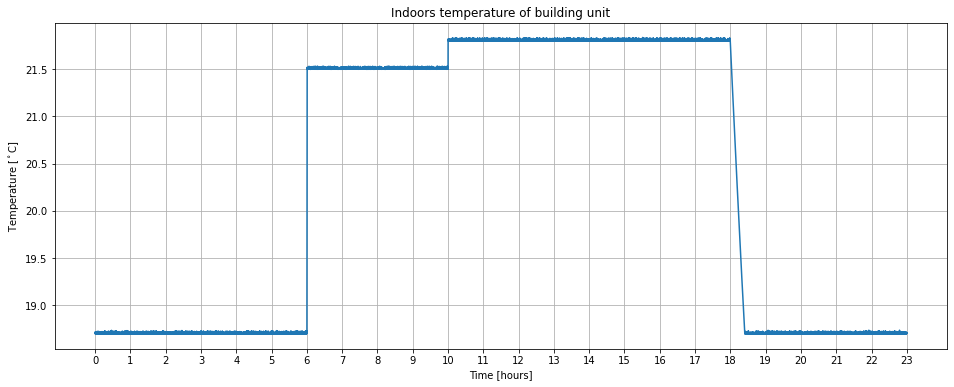

In [ ]:
from scipy.integrate import odeint

K = 273.15
dt = 60*60
simTime = 23*dt
tolerance = 1e-4

tSimArray=np.arange(0,simTime,1)
y0 = 18.7+K
Toutside = -2.2 + K #-2.2 +K
noDataModel = model(Toutside,dt = dt,simTime=simTime )
solnoData = odeint(noDataModel.buildingModel, y0, tSimArray,args=(False,False,False,False ),  rtol=tolerance,atol=tolerance) 

fig = plt.figure(figsize=(16, 6))
plt.grid()
plt.xticks(np.arange(0,24,1))

plt.plot(tSimArray/dt, solnoData-K, label="Model with no added data")
plt.xlabel('Time [hours]')
plt.ylabel('Temperature [$^\circ$C]')
plt.title("Indoors temperature of building unit")


plt.show()

### Compare simulated power usage ang simulated temperature

sum kW 57205.04947353094
average W: 2487176.064066563


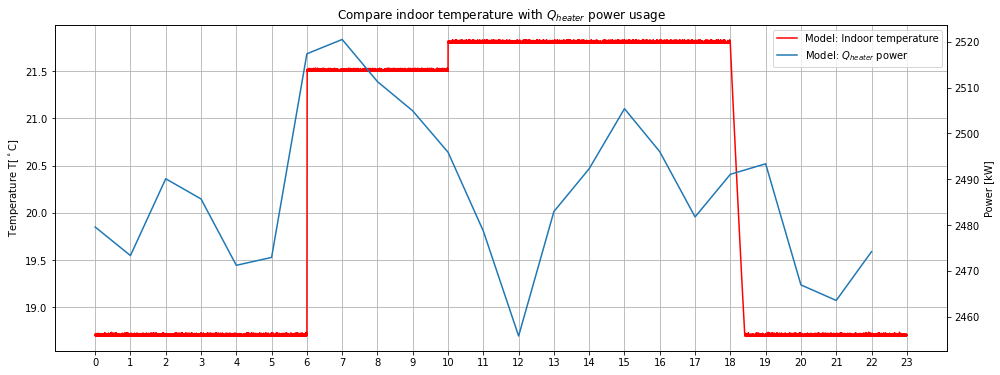

In [ ]:
import pandas as pd
import datetime

fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
plt.title("Compare indoor temperature with $Q_{heater}$ power usage")
plt.grid()

# Simulated temperature plot
legend1=ax1.plot(tSimArray/dt, solnoData-K, label="Model: Indoor temperature", color="red")
ax1.set_xticks(np.arange(0,24,1))
ax1.set_ylabel('Temperature T[$^\circ$C]')
ax1.grid(None)

heaterList = noDataModel.PowerList
timeheaterList = np.array([row[0] for row in heaterList])
ValueheaterList = np.array([row[1] for row in heaterList])

clockHeaterLst,heaterConvLst = findAverageOfHeater(timeheaterList, ValueheaterList)

print("sum kW", sum(heaterConvLst)/1000)
print("average W:", sum(heaterConvLst) / len(heaterConvLst))



# Heater plot
legend2=ax2.plot(clockHeaterLst/3600,heaterConvLst/1000, label="Model: $Q_{heater}$ power")
ax2.set_xticks(np.arange(0,24,1))
ax2.set_xlabel("Time [h]")
ax2.set_ylabel("Power [kW]")
ax2.grid()


lns = legend1+legend2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)
plt.show()

In [ ]:
2487176/1000

2487.176

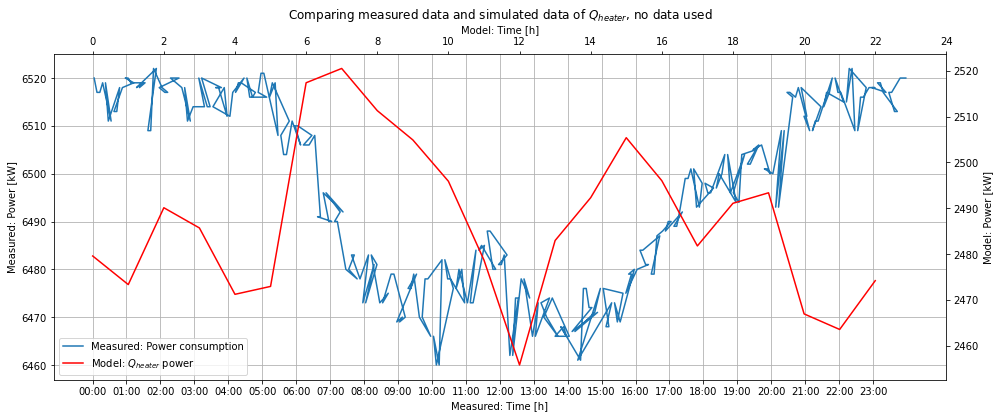

In [ ]:
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(111)
ax2 = fig.add_subplot(111, frame_on=False)
plt.grid()
plt.title("Comparing measured data and simulated data of $Q_{heater}$, no data used")

# Measured data
dfPower3 = dfPower2.copy()
pd.plotting.register_matplotlib_converters()
ax1.set_xlabel('Measured: Time [h]')
ax1.set_ylabel('Measured: Power [kW]')
ax1.grid(None)
dfTemp, idxTemp = convertTime('/content/drive/MyDrive/UiS/1 Master Thesis/data/extract_temp_2.csv')


legend1 = ax1.plot(dfPower3.time, dfPower3.value, label="Measured: Power consumption")
ax1.set_xticks(idxTemp)
# Simulated data

legend2 = ax2.plot(clockHeaterLst/3600,heaterConvLst/1000, label="Model: $Q_{heater}$ power", color="red")
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
ax2.set_xlabel('Model: Time [h]')
ax2.set_ylabel('Model: Power [kW]')
ax2.set_xticks(np.arange(0,24+1,2))

ax2.grid()
lns = legend1+legend2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="lower left")

plt.show()

In [ ]:
sum(dfPower3.value)/len(dfPower3.value)

6496.340277777777

## Outdoor temperature introduced

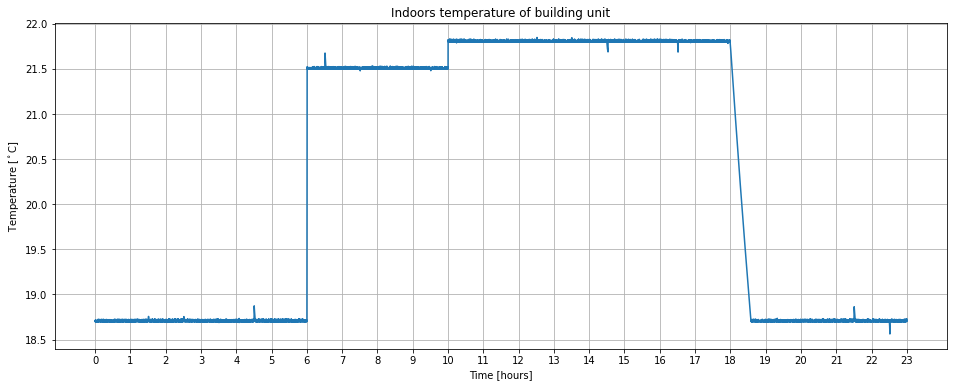

In [ ]:
import pandas as pd
import datetime
from scipy.integrate import odeint

dfOutdoorTemp2 = dfOutdoorTemp.copy()
dfOutdoorTemp2['time'] = dfOutdoorTemp2['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)
dfOutdoorTemp2['value'] = dfOutdoorTemp2['value'].apply(lambda y: y + K)

K = 273.15
dt = 60*60
simTime = 23*dt
tolerance = 1e-4

tSimArray=np.arange(0,simTime,1)
y0 = 18.7+K
Toutside = -2.2 + K #-2.2 +K
outDoorModel = model(Toutside, dt = dt,simTime=simTime, OutsideDataArray=dfOutdoorTemp2 )
soloutDoor = odeint(outDoorModel.buildingModel, y0, tSimArray,args=(True,False,False,False ),  rtol=tolerance,atol=tolerance) 

fig = plt.figure(figsize=(16, 6))
plt.grid()
plt.xticks(np.arange(0,24,1))

plt.plot(tSimArray/dt, soloutDoor-K)
plt.xlabel('Time [hours]')
plt.ylabel('Temperature [$^\circ$C]')
plt.title("Indoors temperature of building unit")

plt.show()

### Compare heating with simulated outdoor temperature and indoor temperature

sum kW 56583.977288247916
average W: 2460.1729255759965


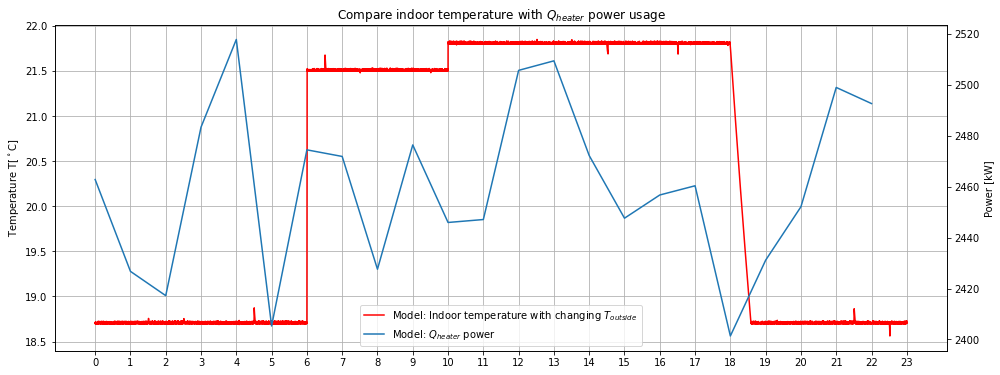

In [ ]:
import pandas as pd
import datetime

fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
plt.title("Compare indoor temperature with $Q_{heater}$ power usage")
plt.grid()

# Simulated temperature plot
legend1=ax1.plot(tSimArray/dt, soloutDoor-K, label="Model: Indoor temperature with changing $T_{outside}$", color="red")
ax1.set_xticks(np.arange(0,24,1))
ax1.set_ylabel('Temperature T[$^\circ$C]')
ax1.grid(None)

heaterListWithOutdoor = outDoorModel.PowerList
timeheaterListWithOutdoor = np.array([row[0] for row in heaterListWithOutdoor])
ValueheaterListWithOutdoor = np.array([row[1] for row in heaterListWithOutdoor])

clockHeaterLstWithOutdoor,heaterConvLstWithOutdoor = findAverageOfHeater(timeheaterListWithOutdoor, ValueheaterListWithOutdoor)

# Heater plot
legend2=ax2.plot(clockHeaterLstWithOutdoor/3600,heaterConvLstWithOutdoor/1000, label="Model: $Q_{heater}$ power")
ax2.set_xticks(np.arange(0,24,1))
ax2.set_xlabel("Time [h]")
ax2.set_ylabel("Power [kW]")
ax2.grid()

print("sum kW", sum(heaterConvLstWithOutdoor)/1000)
print("average W:", (sum(heaterConvLstWithOutdoor) / len(heaterConvLstWithOutdoor)/1000))


lns = legend1+legend2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

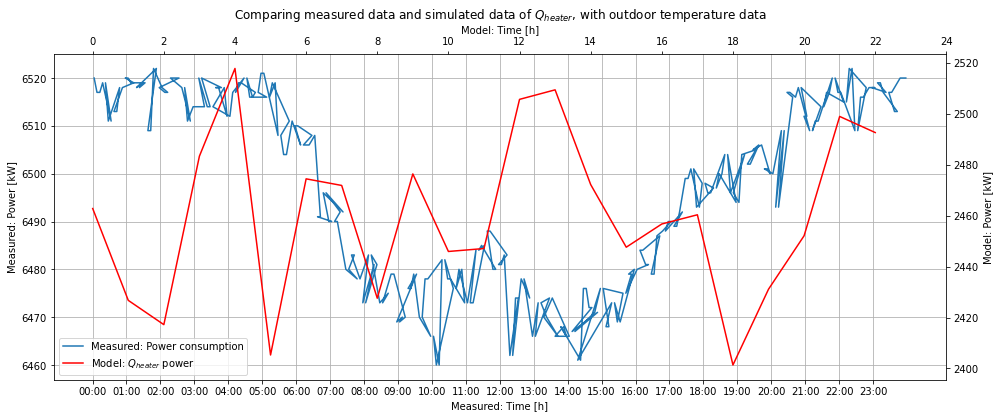

In [ ]:
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(111)
ax2 = fig.add_subplot(111, frame_on=False)
plt.grid()
plt.title("Comparing measured data and simulated data of $Q_{heater}$, with outdoor temperature data")

# Measured data
dfPower3 = dfPower2.copy()
pd.plotting.register_matplotlib_converters()
ax1.set_xlabel('Measured: Time [h]')
ax1.set_ylabel('Measured: Power [kW]')
ax1.grid(None)
dfTemp, idxTemp = convertTime('/content/drive/MyDrive/UiS/1 Master Thesis/data/extract_temp_2.csv')


legend1 = ax1.plot(dfPower3.time, dfPower3.value, label="Measured: Power consumption")
ax1.set_xticks(idxTemp)

# Simulated data
legend2 = ax2.plot(clockHeaterLstWithOutdoor/3600,heaterConvLstWithOutdoor/1000, label="Model: $Q_{heater}$ power", color="red")
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
ax2.set_xlabel('Model: Time [h]')
ax2.set_ylabel('Model: Power [kW]')
ax2.set_xticks(np.arange(0,24+1,2))

ax2.grid()
lns = legend1+legend2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="lower left")

plt.show()

## People introduced

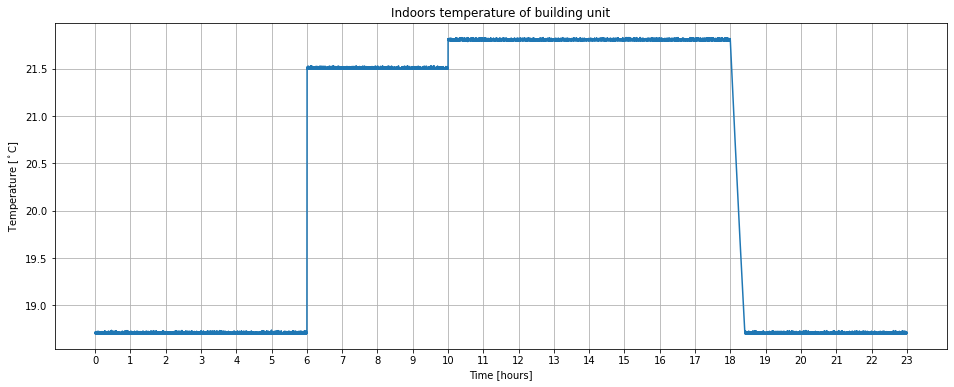

In [ ]:
import pandas as pd
import datetime
from scipy.integrate import odeint

dfPeople3 = dfPeople1.copy()
dfPeople3.value = dfPeople1.value + dfPeople2.value
dfPeople3 = dfPeople3.fillna(0)
dfPeople3['time'] = dfPeople3['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)

K = 273.15
dt = 60*60
simTime = 23*dt
tolerance = 1e-4

tSimArray=np.arange(0,simTime,1)
y0 = 18.7+K
Toutside = -2.2 + K #-2.2 +K
peopleModel = model(Toutside, dt = dt,simTime=simTime, peopleDataArray=dfPeople3 )
solpeople = odeint(peopleModel.buildingModel, y0, tSimArray,args=(False,True,False,False ),  rtol=tolerance,atol=tolerance) 

fig = plt.figure(figsize=(16, 6))
plt.grid()
plt.xticks(np.arange(0,24,1))

plt.plot(tSimArray/dt, solpeople-K)
plt.xlabel('Time [hours]')
plt.ylabel('Temperature [$^\circ$C]')
plt.title("Indoors temperature of building unit")

plt.show()

### Compare heating with simulated people and indoor temperature

sum kW 57402.00139625085
average W: 2495.7391911413415


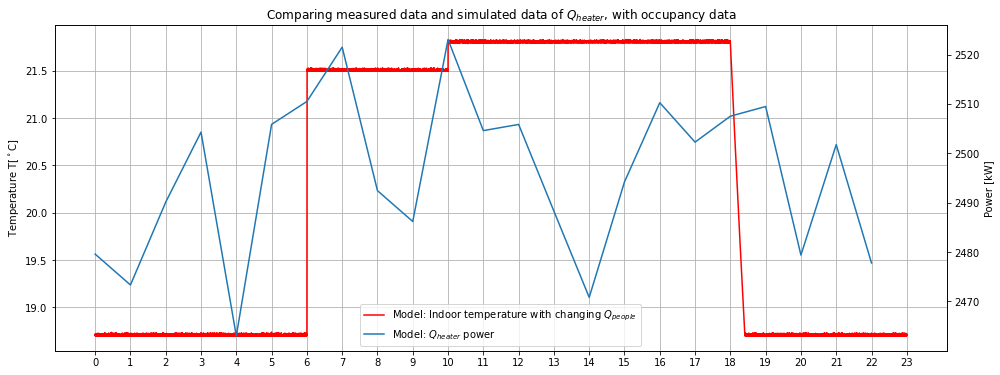

In [ ]:
import pandas as pd
import datetime

fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
plt.title("Comparing measured data and simulated data of $Q_{heater}$, with occupancy data")
plt.grid()

# Simulated temperature plot
legend1=ax1.plot(tSimArray/dt, solpeople-K, label="Model: Indoor temperature with changing $Q_{people}$", color="red")
ax1.set_xticks(np.arange(0,24,1))
ax1.set_ylabel('Temperature T[$^\circ$C]')
ax1.grid(None)

heaterListWWithPeople = peopleModel.PowerList
timeheaterListWWithPeople = np.array([row[0] for row in heaterListWWithPeople])
ValueheaterListWWithPeople = np.array([row[1] for row in heaterListWWithPeople])

clockHeaterLstWWithPeople,heaterConvLstWWithPeople = findAverageOfHeater(timeheaterListWWithPeople, ValueheaterListWWithPeople)

print("sum kW", sum(heaterConvLstWWithPeople)/1000)
print("average W:", (sum(heaterConvLstWWithPeople) / len(heaterConvLstWWithPeople))/1000)

# Heater plot
legend2=ax2.plot(clockHeaterLstWWithPeople/3600,heaterConvLstWWithPeople/1000, label="Model: $Q_{heater}$ power")
ax2.set_xticks(np.arange(0,24,1))
ax2.set_xlabel("Time [h]")
ax2.set_ylabel("Power [kW]")
ax2.grid()


lns = legend1+legend2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

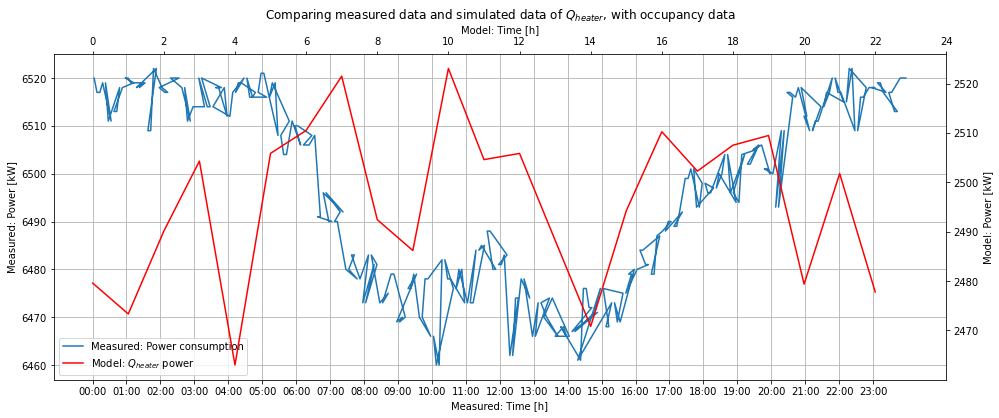

In [ ]:
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(111)
ax2 = fig.add_subplot(111, frame_on=False)
plt.grid()
plt.title("Comparing measured data and simulated data of $Q_{heater}$, with occupancy data")

# Measured data
dfPower3 = dfPower2.copy()
pd.plotting.register_matplotlib_converters()
ax1.set_xlabel('Measured: Time [h]')
ax1.set_ylabel('Measured: Power [kW]')
ax1.grid(None)
dfTemp, idxTemp = convertTime('/content/drive/MyDrive/UiS/1 Master Thesis/data/extract_temp_2.csv')


legend1 = ax1.plot(dfPower3.time, dfPower3.value, label="Measured: Power consumption")
ax1.set_xticks(idxTemp)

# Simulated data
PowerList = peopleModel.PowerList

timePowerList = np.array([row[0] for row in PowerList])
ValuePowerList = np.array([row[1] for row in PowerList])

legend2 = ax2.plot(clockHeaterLstWWithPeople/3600,heaterConvLstWWithPeople/1000, label="Model: $Q_{heater}$ power", color="red")
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
ax2.set_xlabel('Model: Time [h]')
ax2.set_ylabel('Model: Power [kW]')
ax2.set_xticks(np.arange(0,24+1,2))

ax2.grid()
lns = legend1+legend2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="lower left")

plt.show()


## Airflow introduced

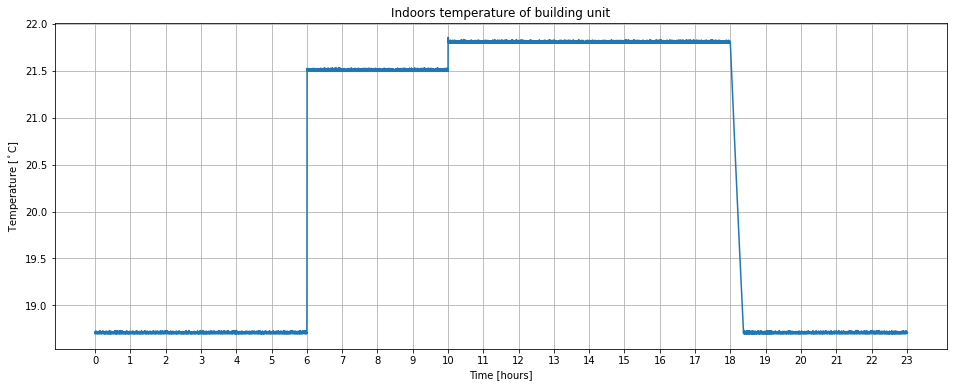

In [ ]:
import pandas as pd
import datetime
from scipy.integrate import odeint

dfFlow2 = dfFlow.copy()
dfFlow2['time'] = dfFlow2['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)

K = 273.15
dt = 60*60
simTime = 23*dt
tolerance = 1e-4

tSimArray=np.arange(0,simTime,1)
y0 = 18.7+K
Toutside = -2.2 + K #-2.2 +K
airFlowModel = model(Toutside, dt = dt,simTime=simTime, QflowDataArray=dfFlow2 )
solairFlow = odeint(airFlowModel.buildingModel, y0, tSimArray,args=(False,False,False,True ),  rtol=tolerance,atol=tolerance) 

fig = plt.figure(figsize=(16, 6))
plt.grid()
plt.xticks(np.arange(0,24,1))

plt.plot(tSimArray/dt, solairFlow-K)
plt.xlabel('Time [hours]')
plt.ylabel('Temperature [$^\circ$C]')
plt.title("Indoors temperature of building unit")

plt.show()

### Compare heating with simulated airflow and indoor temperature

sum kW 57115.095483564495
average W: 2483.265021024543


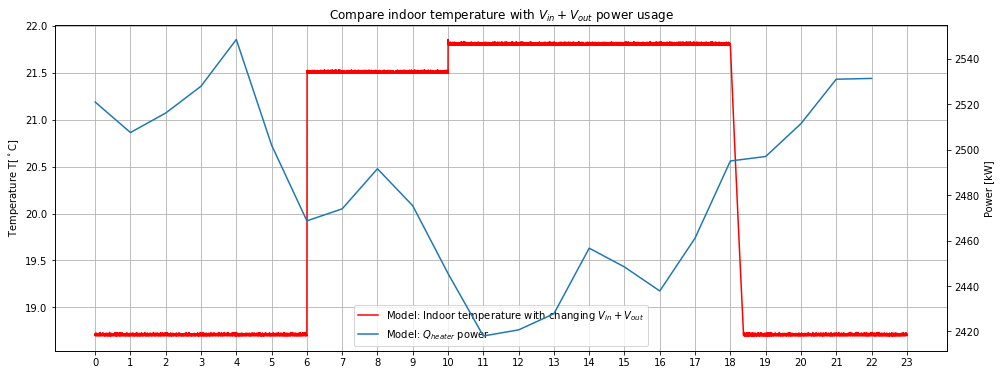

In [ ]:
import pandas as pd
import datetime

fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
plt.title("Compare indoor temperature with $V_{in} + V_{out}$ power usage")
plt.grid()

# Simulated temperature plot
legend1=ax1.plot(tSimArray/dt, solairFlow-K, label="Model: Indoor temperature with changing $V_{in} + V_{out}$", color="red")
ax1.set_xticks(np.arange(0,24,1))
ax1.set_ylabel('Temperature T[$^\circ$C]')
ax1.grid(None)

heaterListWWithAirflow = airFlowModel.PowerList
timeheaterListWWithAirflow = np.array([row[0] for row in heaterListWWithAirflow])
ValueheaterListWWithAirflow = np.array([row[1] for row in heaterListWWithAirflow])

clockHeaterLstWWithAirflow,heaterConvLstWWithAirflow = findAverageOfHeater(timeheaterListWWithAirflow, ValueheaterListWWithAirflow)

print("sum kW", sum(heaterConvLstWWithAirflow)/1000)
print("average W:", sum((heaterConvLstWWithAirflow) / len(heaterConvLstWWithAirflow))/1000)


# Heater plot
legend2=ax2.plot(clockHeaterLstWWithAirflow/3600,heaterConvLstWWithAirflow/1000, label="Model: $Q_{heater}$ power")
ax2.set_xticks(np.arange(0,24,1))
ax2.set_xlabel("Time [h]")
ax2.set_ylabel("Power [kW]")
ax2.grid()


lns = legend1+legend2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

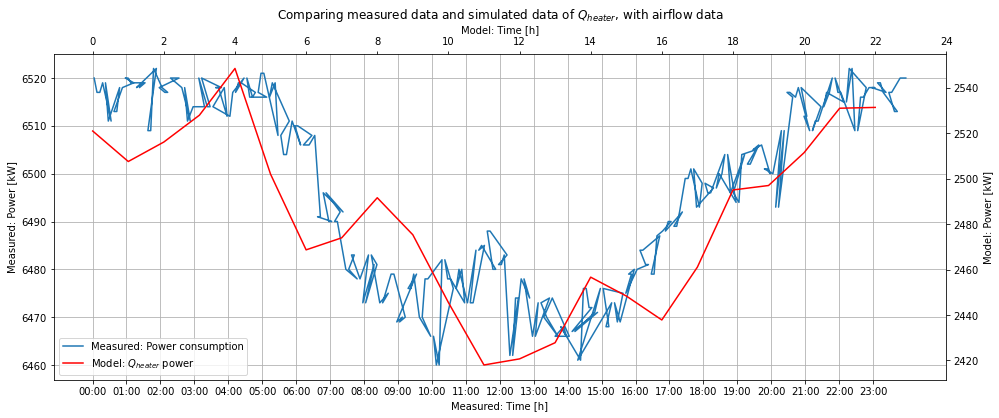

In [ ]:
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(111)
ax2 = fig.add_subplot(111, frame_on=False)
plt.grid()
plt.title("Comparing measured data and simulated data of $Q_{heater}$, with airflow data")

# Measured data
dfPower3 = dfPower2.copy()
pd.plotting.register_matplotlib_converters()
ax1.set_xlabel('Measured: Time [h]')
ax1.set_ylabel('Measured: Power [kW]')
ax1.grid(None)
dfTemp, idxTemp = convertTime('/content/drive/MyDrive/UiS/1 Master Thesis/data/extract_temp_2.csv')


legend1 = ax1.plot(dfPower3.time, dfPower3.value, label="Measured: Power consumption")
ax1.set_xticks(idxTemp)

# Simulated data
PowerList = airFlowModel.PowerList

timePowerList = np.array([row[0] for row in PowerList])
ValuePowerList = np.array([row[1] for row in PowerList])

legend2 = ax2.plot(clockHeaterLstWWithAirflow/3600,heaterConvLstWWithAirflow/1000, label="Model: $Q_{heater}$ power", color="red")
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
ax2.set_xlabel('Model: Time [h]')
ax2.set_ylabel('Model: Power [kW]')
ax2.set_xticks(np.arange(0,24+1,2))

ax2.grid()
lns = legend1+legend2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="lower left")

plt.show()


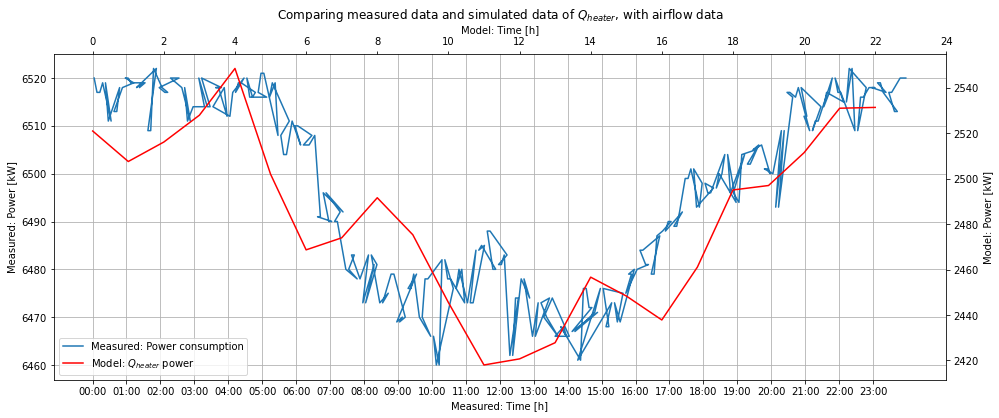

In [ ]:
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(111)
ax2 = fig.add_subplot(111, frame_on=False)
plt.grid()
plt.title("Comparing measured data and simulated data of $Q_{heater}$, with airflow data")

# Measured data
dfPower3 = dfPower2.copy()
pd.plotting.register_matplotlib_converters()
ax1.set_xlabel('Measured: Time [h]')
ax1.set_ylabel('Measured: Power [kW]')
ax1.grid(None)
dfTemp, idxTemp = convertTime('/content/drive/MyDrive/UiS/1 Master Thesis/data/extract_temp_2.csv')


legend1 = ax1.plot(dfPower3.time, dfPower3.value, label="Measured: Power consumption")
ax1.set_xticks(idxTemp)

# Simulated data
PowerList = airFlowModel.PowerList

timePowerList = np.array([row[0] for row in PowerList])
ValuePowerList = np.array([row[1] for row in PowerList])

legend2 = ax2.plot(clockHeaterLstWWithAirflow/3600,heaterConvLstWWithAirflow/1000, label="Model: $Q_{heater}$ power", color="red")
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
ax2.set_xlabel('Model: Time [h]')
ax2.set_ylabel('Model: Power [kW]')
ax2.set_xticks(np.arange(0,24+1,2))

ax2.grid()
lns = legend1+legend2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="lower left")

plt.show()


# Combine all data sets into simulation

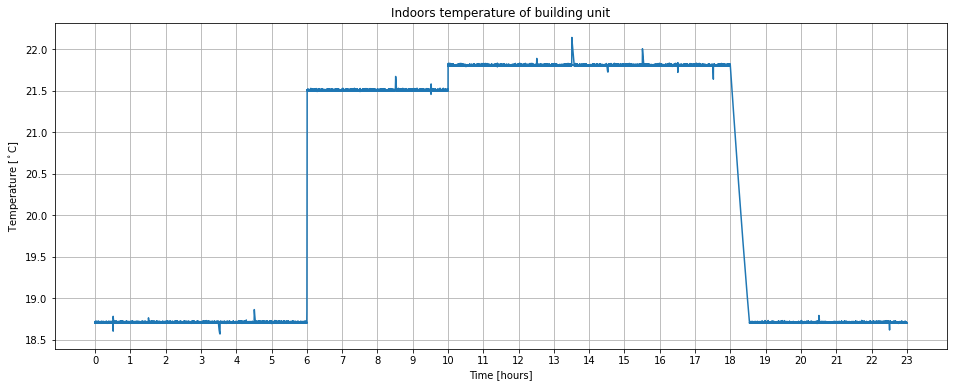

In [ ]:
import pandas as pd
import datetime
from scipy.integrate import odeint

dfFlow2 = dfFlow.copy()
dfFlow2['time'] = dfFlow2['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)
dfOutdoorTemp2 = dfOutdoorTemp.copy()
dfOutdoorTemp2['time'] = dfOutdoorTemp2['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)
dfOutdoorTemp2['value'] = dfOutdoorTemp2['value'].apply(lambda y: y + K)
dfPeople3 = dfPeople1.copy()
dfPeople3.value = dfPeople1.value + dfPeople2.value
dfPeople3 = dfPeople3.fillna(0)
dfPeople3['time'] = dfPeople3['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)

K = 273.15
dt = 60*60
simTime = 23*dt
tolerance = 1e-4

tSimArray=np.arange(0,simTime,1)
y0 = 18.7+K
Toutside = -2.2 + K #-2.2 +K
allDataSetsModel = model(Toutside, dt = dt,simTime=simTime, QflowDataArray=dfFlow2,OutsideDataArray=dfOutdoorTemp2,peopleDataArray=dfPeople3 )
solallDataSets = odeint(allDataSetsModel.buildingModel, y0, tSimArray,args=(True,True,False,True ),  rtol=tolerance,atol=tolerance) 

fig = plt.figure(figsize=(16, 6))
plt.grid()
plt.xticks(np.arange(0,24,1))

plt.plot(tSimArray/dt, solallDataSets-K)
plt.xlabel('Time [hours]')
plt.ylabel('Temperature [$^\circ$C]')
plt.title("Indoors temperature of building unit")

plt.show()

sum kW 5659253.020149075
average W: 2460.544791369157


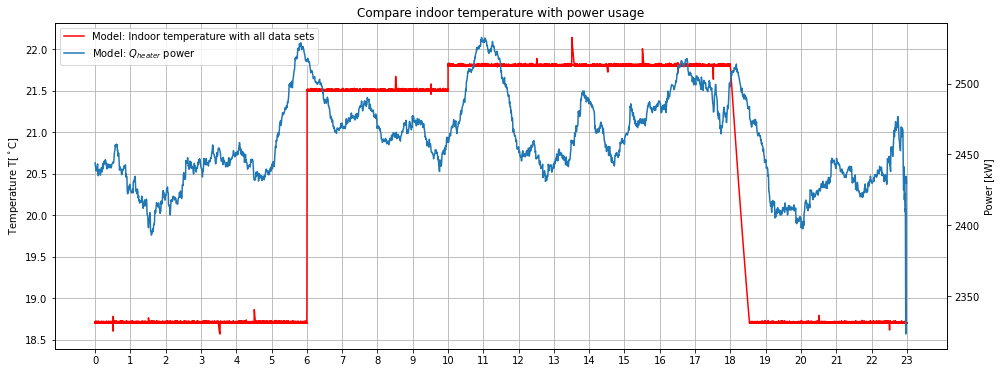

In [ ]:
import pandas as pd
import datetime

fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
plt.title("Compare indoor temperature with power usage")
plt.grid()

# Simulated temperature plot
legend1=ax1.plot(tSimArray/dt, solallDataSets-K, label="Model: Indoor temperature with all data sets", color="red")
ax1.set_xticks(np.arange(0,24,1))
ax1.set_ylabel('Temperature T[$^\circ$C]')
ax1.grid(None)

heaterListWWithallDataSets = allDataSetsModel.PowerList
timeheaterListWWithallDataSets = np.array([row[0] for row in heaterListWWithallDataSets])
ValueheaterListWWithallDataSets = np.array([row[1] for row in heaterListWWithallDataSets])

clockHeaterLstWWithallDataSets,heaterConvLstWWithallDataSets = findAverageOfHeater(timeheaterListWWithallDataSets, ValueheaterListWWithallDataSets, h=0.01)

print("sum kW", sum(heaterConvLstWWithallDataSets)/1000)
print("average W:", sum((heaterConvLstWWithallDataSets) / len(heaterConvLstWWithallDataSets))/1000)


# Heater plot
legend2=ax2.plot(clockHeaterLstWWithallDataSets/3600,heaterConvLstWWithallDataSets/1000, label="Model: $Q_{heater}$ power")
ax2.set_xticks(np.arange(0,24,1))
ax2.set_xlabel("Time [h]")
ax2.set_ylabel("Power [kW]")
ax2.grid()


lns = legend1+legend2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

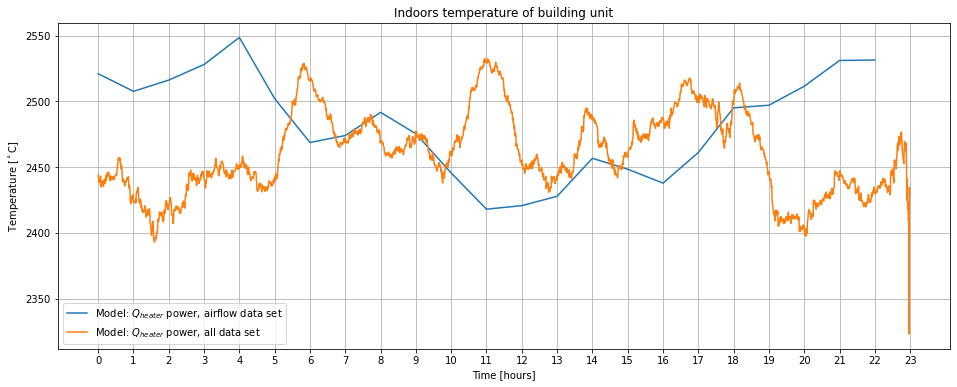

In [ ]:
fig = plt.figure(figsize=(16, 6))
plt.grid()
plt.xticks(np.arange(0,24,1))

plt.plot(clockHeaterLstWWithAirflow/3600,heaterConvLstWWithAirflow/1000, label="Model: $Q_{heater}$ power, airflow data set")
plt.plot(clockHeaterLstWWithallDataSets/3600,heaterConvLstWWithallDataSets/1000, label="Model: $Q_{heater}$ power, all data set")
plt.xlabel('Time [hours]')
plt.ylabel('Temperature [$^\circ$C]')
plt.title("Indoors temperature of building unit")
plt.legend()
plt.show()

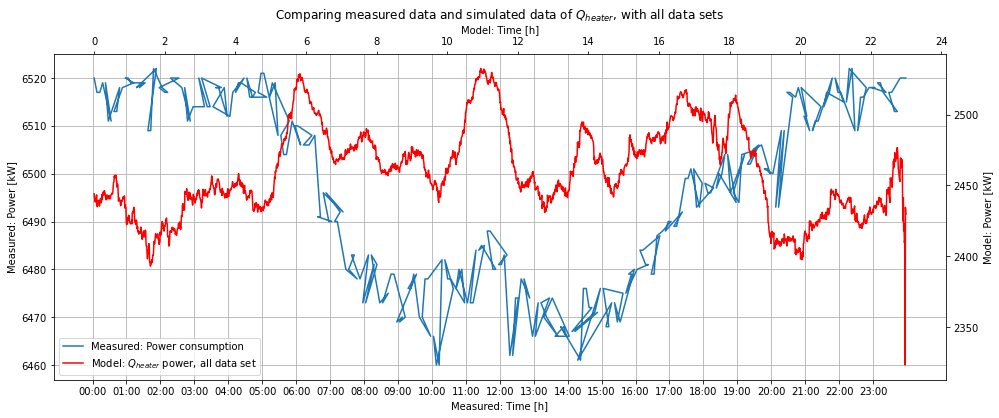

In [ ]:
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(111)
ax2 = fig.add_subplot(111, frame_on=False)
plt.grid()
plt.title("Comparing measured data and simulated data of $Q_{heater}$, with all data sets")

# Measured data
dfPower3 = dfPower2.copy()
pd.plotting.register_matplotlib_converters()
ax1.set_xlabel('Measured: Time [h]')
ax1.set_ylabel('Measured: Power [kW]')
ax1.grid(None)
dfTemp, idxTemp = convertTime('/content/drive/MyDrive/UiS/1 Master Thesis/data/extract_temp_2.csv')


legend1 = ax1.plot(dfPower3.time, dfPower3.value, label="Measured: Power consumption")
ax1.set_xticks(idxTemp)

# Simulated data

legend2 = ax2.plot(clockHeaterLstWWithallDataSets/3600,heaterConvLstWWithallDataSets/1000, label="Model: $Q_{heater}$ power, all data set", color="red")
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
ax2.set_xlabel('Model: Time [h]')
ax2.set_ylabel('Model: Power [kW]')
ax2.set_xticks(np.arange(0,24+1,2))

ax2.grid()
lns = legend1+legend2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="lower left")

plt.show()


# Test

In [ ]:
dt = 3600
clockLst= np.arange(0,23,0.5)*dt 
timeHeater = np.array(timeLst) 
ValueHeater = np.array(valueLst)
averageList = list()

for i in clockLst:
  test2 = np.where(np.logical_and(timeHeater >= i,timeHeater <= i+dt))

  test3 = ValueHeater[test2[0]]
  test4 = np.average(test3)
  averageList.append(test4)

foo = np.array(clockLst)
loo = np.array(averageList)